# Lab: PJM Hourly Energy Forecasting with SageMaker DeepAR

## Overview
In this lab, we will use the **PJM Hourly Energy Consumption Dataset** to predict future electricity demand. We will use **Amazon SageMaker's built-in DeepAR algorithm**, which is a supervised learning algorithm for forecasting scalar (one-dimensional) time series using Recurrent Neural Networks (RNNs).

### Lab Objectives:
1. **Load and Explore Data**: Read the CSV data and visualize the energy consumption.
2. **Preprocess for DeepAR**: Convert the data into the JSON format required by DeepAR.
3. **Train a Model**: Use SageMaker Estimators to train a forecasting model.
4. **Deploy and Predict**: Deploy an endpoint and visualize predictions against actuals.
5. **Reproduce in Canvas**: Learn how to achieve the same results using the No-Code SageMaker Canvas interface.

---

## 1. Setup and Environment

First, we import the necessary libraries. We will use `boto3` for AWS services, `sagemaker` for model training, and `pandas`/`matplotlib` for data manipulation.

In [1]:
import sagemaker
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from sagemaker import image_uris

# Set up SageMaker session and role
session = sagemaker.Session()
region = session.boto_region_name
role = sagemaker.get_execution_role()
bucket = session.default_bucket()
prefix = 'sagemaker/pjm-energy-forecasting'

print(f"Region: {region}")
print(f"S3 Bucket: {bucket}")
print(f"Role: {role}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Region: us-east-1
S3 Bucket: sagemaker-us-east-1-254283132378
Role: arn:aws:iam::254283132378:role/service-role/AmazonSageMaker-ExecutionRole-20251215T191125


## 2. Load Sample Data

In a real scenario, you would have the full dataset in a folder named `data/hourly_energy_consumption`. 

**Note:** First, select a PJM region you want to explore and model?

The specific regions and utility zones included in the dataset are:

- AEP: American Electric Power
- COMED: Commonwealth Edison
- DAYTON: Dayton Power & Light
- DEOK: Duke Energy Ohio/Kentucky
- DOM: Dominion Virginia Power
- DUQ: Duquesne Light Company
- EKPC: East Kentucky Power Cooperative
- FE: FirstEnergy
- NI: Northern Illinois (often associated with ComEd)
- PJME: PJM East Region
- PJMW: PJM West Region


In [2]:
#which PJM Region dataset would you like to explore?

PJM_region = "AEP"


# Read the data
df = pd.read_csv("data/hourly_energy_consumption/" + PJM_region + "_hourly.csv")
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


## 3. Exploratory Data Analysis (EDA)

We need to clean the data and visualize it to understand the patterns (seasonality, trends). 

1. Convert `Datetime` to a proper datetime object.
2. Set `Datetime` as the index.
3. Handle duplicates or missing values.

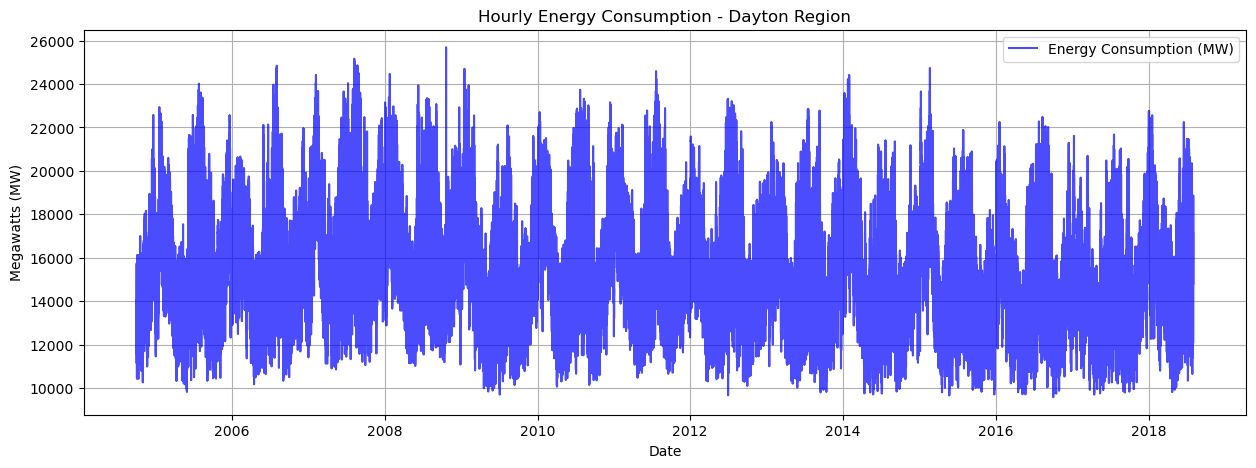

In [3]:
# 1. Convert to Datetime
df['Datetime'] = pd.to_datetime(df['Datetime'])

# 2. Set Index
df = df.set_index('Datetime')

# 3. Sort index to ensure chronological order
df = df.sort_index()

# 4. Plotting a subset
plt.figure(figsize=(15, 5))
plt.plot(df.index, df[PJM_region + '_MW'], label='Energy Consumption (MW)', color='blue', alpha=0.7)
plt.title('Hourly Energy Consumption - Dayton Region')
plt.ylabel('Megawatts (MW)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

### Preparing Data for DeepAR

DeepAR requires the data to be in a specific JSON format. We also need to decide on:
- **Context Length**: How far back the model looks (e.g., 1 week = 168 hours).
- **Prediction Length**: How far forward we predict (e.g., 24 hours).

We will split the data into **Training** (past data) and **Testing** (data including the future we want to predict).

In [4]:
freq = 'H' # Hourly data
prediction_length = 24 # Predict next 24 hours
context_length = 24 * 7 # Look back 1 week

# Ensure regular frequency (fill missing hours if any)
ts_data = df[PJM_region + '_MW'].resample(freq).mean().ffill()

# Split Train and Test
# Train ends 24 hours before the end of the dataset
train_series = ts_data.iloc[:-prediction_length]
test_series = ts_data # Test includes the whole series (DeepAR uses the end to evaluate)

print(f"Train end date: {train_series.index[-1]}")
print(f"Test end date: {test_series.index[-1]}")

Train end date: 2018-08-02 00:00:00
Test end date: 2018-08-03 00:00:00


/tmp/ipykernel_1705/4096969136.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts_data = df[PJM_region + '_MW'].resample(freq).mean().ffill()


In [5]:
# Helper function to convert to DeepAR JSON format
def write_json_dataset(series, filename):
    with open(filename, 'wb') as f:
        # DeepAR expects: start timestamp and target array
        json_obj = {
            "start": str(series.index[0]),
            "target": list(series.values)
        }
        f.write(json.dumps(json_obj).encode('utf-8'))
        f.write(b'\n')
    print(f"Created {filename}")

# Create local JSON files
write_json_dataset(train_series, 'train.json')
write_json_dataset(test_series, 'test.json')

# Upload to S3
train_path = session.upload_data('train.json', bucket=bucket, key_prefix=f'{prefix}/train')
test_path = session.upload_data('test.json', bucket=bucket, key_prefix=f'{prefix}/test')

print(f"Training data uploaded to: {train_path}")
print(f"Test data uploaded to: {test_path}")

Created train.json
Created test.json
Training data uploaded to: s3://sagemaker-us-east-1-254283132378/sagemaker/pjm-energy-forecasting/train/train.json
Test data uploaded to: s3://sagemaker-us-east-1-254283132378/sagemaker/pjm-energy-forecasting/test/test.json


## 4. Train DeepAR Model

We retrieve the built-in DeepAR Docker image and configure the Estimator.

```python
# Retrieve DeepAR Image URI
image_uri = image_uris.retrieve(region=region, framework='forecasting-deepar')

# Define the Estimator
estimator = sagemaker.estimator.Estimator(
    image_uri=image_uri,
    role=role,
    instance_count=1,
    instance_type='ml.c5.xlarge', # Cost-effective instance for training
    output_path=f's3://{bucket}/{prefix}/output',
    sagemaker_session=session
)

# Set Hyperparameters
estimator.set_hyperparameters(
    time_freq=freq,
    context_length=str(context_length),
    prediction_length=str(prediction_length),
    epochs='20',           # Low epochs for quick lab execution
    early_stopping_patience='10',
    num_layers='2'
)

# Train the model
print("Starting training... this may take 5-10 minutes.")
estimator.fit(inputs={'train': train_path, 'test': test_path}, logs=False)
```

In [6]:
# Retrieve DeepAR Image URI
image_uri = image_uris.retrieve(region=region, framework='forecasting-deepar')

estimator = sagemaker.estimator.Estimator(
    image_uri=image_uri,
    role=role,
    instance_count=1,
    instance_type='ml.c5.xlarge',
    output_path=f's3://{bucket}/{prefix}/output',
    sagemaker_session=session
)

## start with a simple model:

estimator.set_hyperparameters(
    time_freq='H',
    prediction_length='24',
    context_length='72',
    epochs='15',
    early_stopping_patience='10',
    learning_rate='0.001',      # Use decimal notation instead of scientific '1e-3'
    num_layers='1',
    num_cells='20',
    dropout_rate='0.1'
)


## increase moel complexity for better accuracy

#estimator.set_hyperparameters(
#    time_freq='H',
#    prediction_length='168',
#    context_length='336',
#    epochs='30',
#    early_stopping_patience='10',
#    learning_rate='0.001',      # Use decimal notation instead of scientific '1e-3'
#    num_layers='2',
#    num_cells='40',
#    dropout_rate='0.1'
#)


In [7]:
# Train the model
estimator.fit(inputs={'train': train_path, 'test': test_path}, logs=False)

INFO:sagemaker:Creating training-job with name: forecasting-deepar-2025-12-20-21-16-10-036


Starting training... this may take 5-10 minutes.

2025-12-20 21:16:11 Starting - Starting the training job..
2025-12-20 21:16:25 Starting - Preparing the instances for training...
2025-12-20 21:16:47 Downloading - Downloading input data...
2025-12-20 21:17:07 Downloading - Downloading the training image...................
2025-12-20 21:18:49 Training - Training image download completed. Training in progress........................................................................
2025-12-20 21:24:50 Uploading - Uploading generated training model.
2025-12-20 21:25:03 Completed - Training job completed


## 5. Deploy and Predict

Once training is complete, we deploy the model to an endpoint for real-time inference.

In [8]:
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

# Deploy the model
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer()
)

print("Endpoint deployed.")

INFO:sagemaker:Creating model with name: forecasting-deepar-2025-12-20-21-26-03-183
INFO:sagemaker:Creating endpoint-config with name forecasting-deepar-2025-12-20-21-26-03-183
INFO:sagemaker:Creating endpoint with name forecasting-deepar-2025-12-20-21-26-03-183


--------!Endpoint deployed.


### Make Predictions
We send the time series data to the endpoint. DeepAR will look at the provided data and forecast the next 24 hours (as defined in `prediction_length`).

/tmp/ipykernel_1705/3058184617.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_date_range = pd.date_range(start=train_series.index[-1] + pd.Timedelta(hours=1), periods=prediction_length, freq='H')


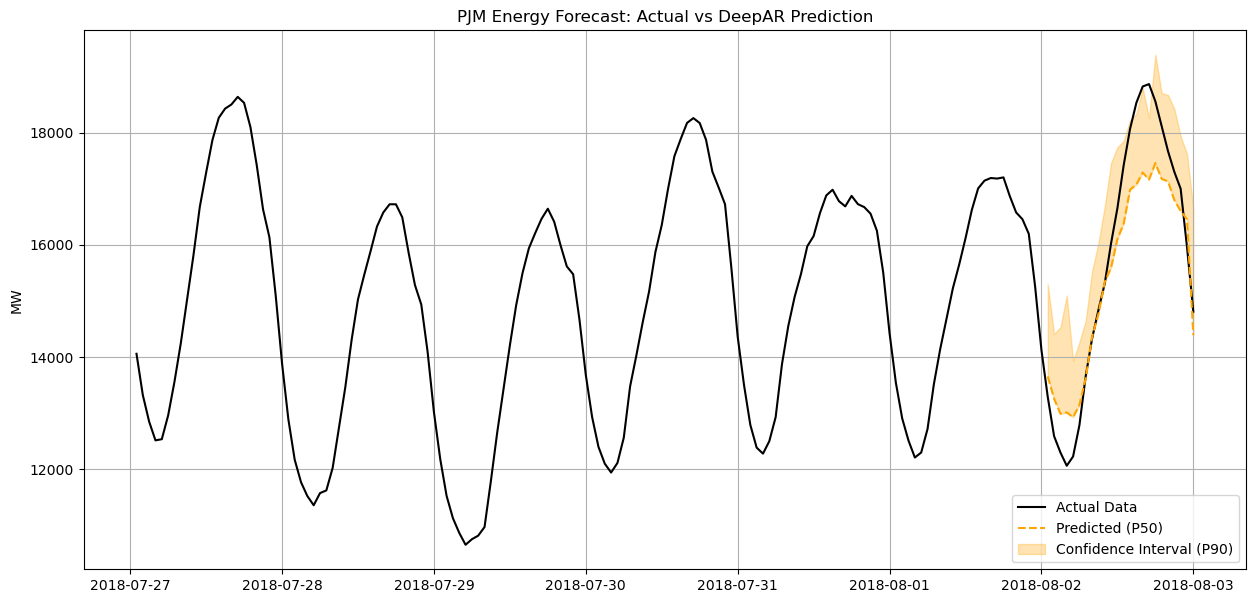

In [9]:
# Prepare request
# We send the 'train' series. DeepAR will predict the continuation.
request_data = {
    "instances": [
        {"start": str(train_series.index[0]), "target": list(train_series.values)}
    ],
    "configuration": {"num_samples": 50, "output_types": ["quantiles"], "quantiles": ["0.5", "0.9"]}
}

# Get prediction
prediction = predictor.predict(request_data)

# Extract forecasts
forecast_key = prediction['predictions'][0]
p50 = forecast_key['quantiles']['0.5'] # Median prediction
p90 = forecast_key['quantiles']['0.9'] # 90th percentile (upper bound)

# Create a DataFrame for plotting
forecast_date_range = pd.date_range(start=train_series.index[-1] + pd.Timedelta(hours=1), periods=prediction_length, freq='H')

plt.figure(figsize=(15, 7))

# Plot actual historical data (Zoom in on last week for visibility)
zoom_start = -168 
plt.plot(test_series.index[zoom_start:], test_series.values[zoom_start:], label='Actual Data', color='black')

# Plot forecast
plt.plot(forecast_date_range, p50, label='Predicted (P50)', color='orange', linestyle='--')
plt.fill_between(forecast_date_range, p50, p90, color='orange', alpha=0.3, label='Confidence Interval (P90)')

plt.title('PJM Energy Forecast: Actual vs DeepAR Prediction')
plt.ylabel('MW')
plt.legend()
plt.grid()
plt.show()

## 6. Clean-up

**Important:** Delete the endpoint to avoid incurring charges.

In [ ]:
predictor.delete_endpoint()
print("Endpoint deleted.")

# Optional: Remove uploaded data from S3
# sagemaker.Session().delete_object(bucket=bucket, key=prefix)

## 7. Instructions for Reproducing in SageMaker Canvas

SageMaker Canvas allows you to build this model without writing any code. Follow these steps to reproduce the results:

### Step 1: Import Data
1. Open **SageMaker Canvas** from the AWS Console.
2. Navigate to **Data** -> **Import**.
3. Upload the `DAYTON_hourly.csv` file (you can download it from the `data/` folder in the Jupyter file browser).
4. Preview the data and choose **Import**.

### Step 2: Build a Model
1. Go to **My Models** -> **New Model**.
2. Name it `PJM-Energy-Forecast`.
3. Select **Predictive Analysis**.

### Step 3: Configure Training
1. Select your imported dataset.
2. **Target Column**: Select `DAYTON_MW`.
3. Canvas will automatically detect this is a Time Series problem. If not, click **Configure**.
    - **Item ID**: If you had multiple regions in one file, you would select the region name here. Since we only have one, you can leave it blank or add a dummy column.
    - **Time Stamp**: Select `Datetime`.
    - **Forecast Horizon**: Set to `24` (to match our code).
4. Click **Preview model** to see data quality insights.

### Step 4: Train
1. Click **Standard Build** (takes 1-2 hours but is more accurate) or **Quick Build** (15 mins).
2. Wait for training to complete.

### Step 5: Analyze and Predict
1. Once trained, view the **Overview** tab to see accuracy metrics (wQL, RMSE).
2. Go to the **Predict** tab.
3. You can generate a **Single Prediction** (what-if analysis) or verify against the held-out test set.